In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as ss
import matplotlib.pyplot as plt
import json
import os
from bmtool.util.util import load_nodes_from_paths

from analysis import plot, utils, process # imoporting analysis module enables import from model folder
from build_input import get_populations, input_pairs_from_file

%matplotlib inline

TRIAL_NAME = "long_nassy_20"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

### Load data

In [2]:
stimulus_type, config = utils.stimulus_type_from_trial_name(TRIAL_NAME)
isstandard = stimulus_type == 'short' or stimulus_type == 'long'  # do not apply for baseline case

pop_color = plot.pop_color
pop_names = plot.pop_names

In [3]:
result_config_file = os.path.join('..', 'Analysis', TRIAL_PATH, config)
if not os.path.isfile(result_config_file):
    result_config_file = os.path.join(os.path.split(result_config_file)[0], utils.STIMULUS_CONFIG['else'])

config_hp = utils.ConfigHelper(result_config_file)
t_stop = config_hp.get_attr('run', 'tstop') / 1000

INPUT_PATH, _ = os.path.split(config_hp.get_attr('inputs', 'baseline_spikes', 'input_file'))
STIM_FILE = config_hp.get_attr('inputs', 'thalamus_spikes', 'input_file')
NODE_FILES = config_hp.get_attr('networks', 'nodes')
SPIKE_FILE = os.path.join('..', 'Analysis', TRIAL_PATH,
                          os.path.split(config_hp.get_attr('output', 'spikes_file'))[1])

stim_file = 'standard_stimulus' if isstandard else os.path.splitext(os.path.split(STIM_FILE)[1])[0]
with open(os.path.join(INPUT_PATH, stim_file + '.json')) as f:
    stim_setting = json.load(f)
stim_params = stim_setting[stimulus_type if isstandard else 'stim_params']

t_start = stim_params['t_start']
on_time, off_time = stim_params['on_time'], stim_params['off_time']

In [4]:
network_name = 'cortex'

node_df = load_nodes_from_paths(NODE_FILES)[network_name]
pop_ids = get_populations(node_df, pop_names, only_id=True)

spikes_df = utils.load_spikes_to_df(SPIKE_FILE, network_name)

### Get population spike rate

In [5]:
# node ids in assemblies
_, Assembly_ids = input_pairs_from_file(os.path.join(INPUT_PATH, 'Assembly_ids.csv'))
assy_ids = {a: ids for a, ids in enumerate(Assembly_ids)}

# indices of assemblies stimulated
assy_idx = list(range(len(Assembly_ids))) if isstandard \
    else stim_setting['setting']['assembly_index']

# indices of assemblies not stimuluted
rest_assy = assy_ids.keys() - set(assy_idx)
if rest_assy:
    assy_ids[-1] = sorted(n for a in rest_assy for n in assy_ids[a])
assy_ids = {a: ids for a, ids in assy_ids.items() if a not in rest_assy}
rest_assy = bool(rest_assy)

PN_pop_names = ['CP', 'CS']
ITN_pop_names = ['FSI', 'LTS']
group_ids = {(a, p): sorted(set(pop_ids[p]) & set(ids))
             for a, ids in assy_ids.items() for p in PN_pop_names}
assy_names = {a: (f'assembly {a:d}' if a >= 0 else 'rest') for a in assy_ids}
group_names = {(a, p): p + ' ' + assy_names[a] for a in assy_ids for p in PN_pop_names}

In [6]:
fs = 400.
time = np.linspace(0., 1000. * t_stop, int(t_stop * fs), endpoint=False)

filt_order = 4  # filter order
filt_cutoff = 8.  # Hz. filter cutoff frequency
sos = ss.butter(N=filt_order, Wn=filt_cutoff, fs=fs, output='sos')
freq_range = (5.0, 70.)  # Hz. Scalogram frequency range

In [7]:
grp_rspk = process.group_spike_rate_to_xarray(spikes_df, time, group_ids)
pop_rspk = process.group_spike_rate_to_xarray(spikes_df, time,
    {p: pop_ids[p] for p in ITN_pop_names}, group_dims='population')  # include only ITN
for da in [grp_rspk, pop_rspk]:
    axis = da.spike_rate.dims.index('time')
    da.update(dict(smoothed_spike_rate=xr.zeros_like(da.spike_rate)))
    da.smoothed_spike_rate[:] = ss.sosfilt(sos, da.spike_rate, axis=axis)
    da.attrs.update({'filt_order': filt_order, 'filt_cutoff': filt_cutoff})
    coords = {k: v for k, v in da.spike_rate.coords.items() if k != 'time'}
    da.update(plot.cwt_spectrogram_xarray(da.spike_rate, da.fs, axis = axis,
        time=da.spike_rate.coords['time'], channel_coords=coords, freq_range=freq_range))

display(grp_rspk)
display(pop_rspk)

e:\Users\lenovo\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
e:\Users\lenovo\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


<xarray.Dataset>
Dimensions:                      (assembly: 20, population: 2, time: 18400, frequency: 22)
Coordinates:
  * time                         (time) float64 1.25 3.75 ... 4.6e+04 4.6e+04
  * assembly                     (assembly) int64 0 1 2 3 4 5 ... 15 16 17 18 19
  * population                   (population) object 'CP' 'CS'
  * frequency                    (frequency) float64 5.568 6.25 ... 56.12 63.0
Data variables:
    spike_rate                   (assembly, population, time) float64 0.0 ......
    population_number            (assembly, population) int32 205 195 ... 201
    smoothed_spike_rate          (assembly, population, time) float64 0.0 ......
    PSD                          (assembly, population, frequency, time) float64 ...
    cone_of_influence_frequency  (time) float64 1.146e+03 381.8 ... 1.146e+03
Attributes:
    fs:           400.0
    filt_order:   4
    filt_cutoff:  8.0

<xarray.Dataset>
Dimensions:                      (population: 2, time: 18400, frequency: 22)
Coordinates:
  * time                         (time) float64 1.25 3.75 ... 4.6e+04 4.6e+04
  * population                   (population) object 'FSI' 'LTS'
  * frequency                    (frequency) float64 5.568 6.25 ... 56.12 63.0
Data variables:
    spike_rate                   (population, time) float64 0.0 0.0 ... 3.0 3.0
    population_number            (population) int32 1200 800
    smoothed_spike_rate          (population, time) float64 0.0 0.0 ... 4.829
    PSD                          (population, frequency, time) float64 10.84 ...
    cone_of_influence_frequency  (time) float64 1.146e+03 381.8 ... 1.146e+03
Attributes:
    fs:           400.0
    filt_order:   4
    filt_cutoff:  8.0

### Get oscillations

In [8]:
wave_lines = {'beta': '--', 'gamma': ':'}
waves = list(wave_lines)

wave_kwargs = {
    'filter': dict(
        waves = {'beta': (14.5, 23.5), 'gamma': (30.0, 44.0)},
        transform = process.wave_hilbert,
        filt_order = 4
    ),
    'wavelet': dict(
        waves = {'beta': 19.0, 'gamma': 37.0},
        transform = process.wave_cwt,
        bandwidth = 2.0  # time band (inverse to frequency band)
    )
}

In [9]:
method = 'wavelet'
grp_waves = process.get_waves(grp_rspk.spike_rate, fs=grp_rspk.fs, **wave_kwargs[method])
pop_waves = process.get_waves(pop_rspk.spike_rate, fs=pop_rspk.fs, **wave_kwargs[method])

### Analyze population spike rate

In [10]:
win_extend = 0.4  # extend window by 0.3 sec after stimulus off
windows = 1000. * process.get_stim_windows(on_time, off_time, t_start, t_stop,
                                           win_extend=win_extend)

# assemblies to be plotted in each unique stimulus cycle {unique cycle id: assembly ids}
if stimulus_type == 'long':
    cyc_to_assy = {i: assy_idx[:2] for i in range(len(assy_idx))}
elif stimulus_type == 'short':
    cyc_to_assy = {0: assy_idx[:3]}
else:
    cyc_to_assy = {0: assy_idx}

# indices of windows with the same stimulus cycles {unique cycle id: cycle numbers}
n_unique_cycle = len(cyc_to_assy)
win_grp_idx = {i: np.arange(i, windows.shape[0], n_unique_cycle)
               for i in range(n_unique_cycle)}

In [11]:
_, grp_rspk_cyc_onff, grp_rspk_cyc_std = process.get_windowed_data(
    grp_rspk.spike_rate, windows, win_grp_idx)
_, _, grp_rspk_cyc_avg = process.get_windowed_data(
    grp_rspk.smoothed_spike_rate, windows, win_grp_idx)
_, _, grp_waves_avg = process.get_windowed_data(grp_waves, windows, win_grp_idx)
_, _, grp_psd_cyc_avg = process.get_windowed_data(grp_rspk.PSD, windows, win_grp_idx)

_, pop_rspk_cyc_onff, pop_rspk_cyc_std = process.get_windowed_data(
    pop_rspk.spike_rate, windows, win_grp_idx)
_, _, pop_rspk_cyc_avg = process.get_windowed_data(
    pop_rspk.smoothed_spike_rate, windows, win_grp_idx)
_, _, pop_waves_avg = process.get_windowed_data(pop_waves, windows, win_grp_idx)
_, _, pop_psd_cyc_avg = process.get_windowed_data(pop_rspk.PSD, windows, win_grp_idx)


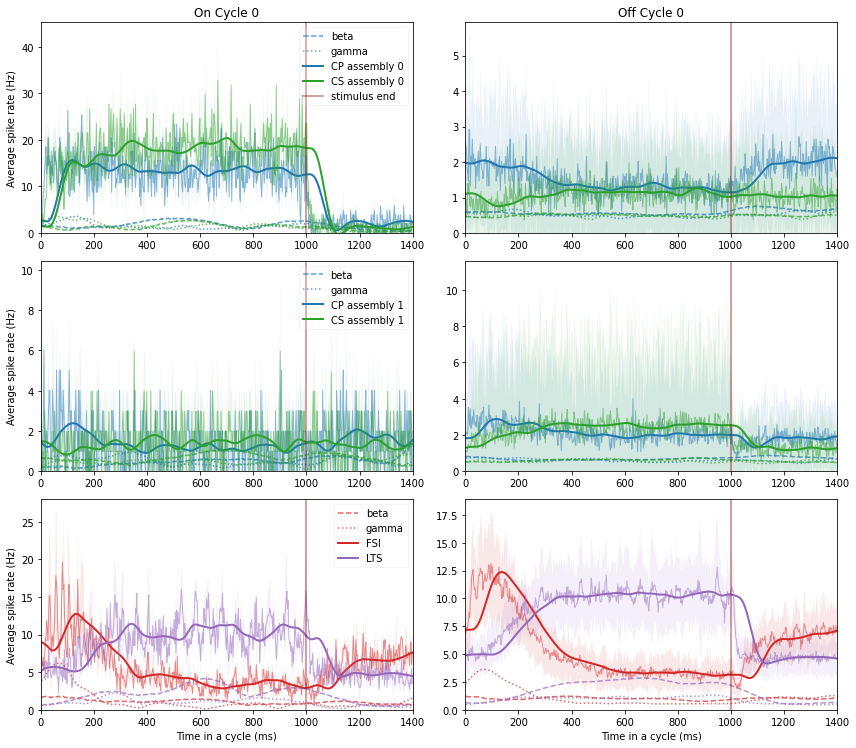

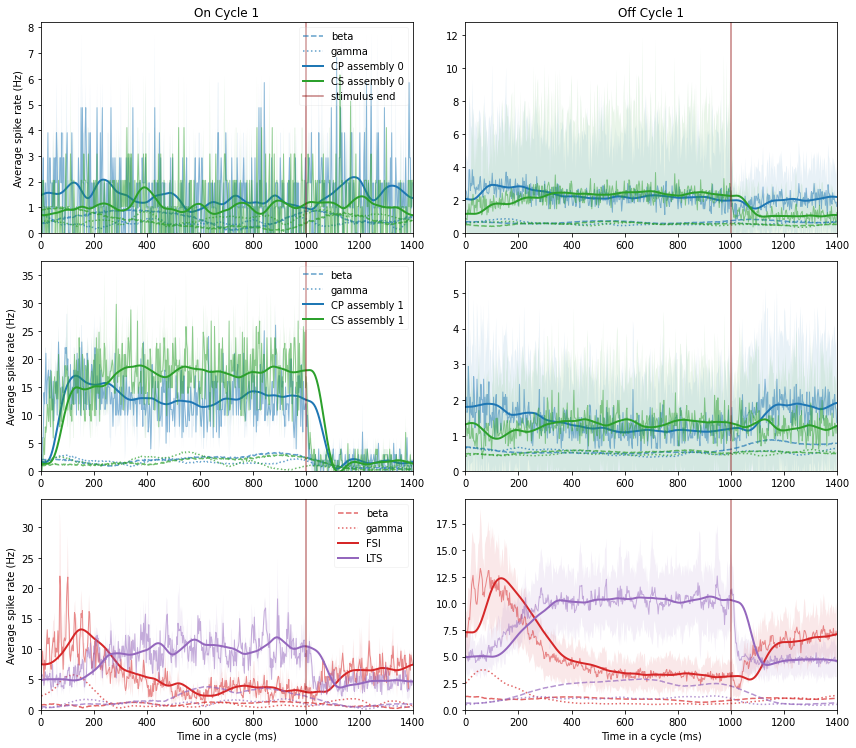

In [12]:
figsize = (6, 3.5)
show_trials = False
show_raw = True
show_amp = True

show_unique_cyc = 2  # maximum number of unique cycles to show
show_unique_cyc = list(cyc_to_assy.keys())[:show_unique_cyc]
show_off = int(n_unique_cycle > 1) + 1

def plot_rspk(ax, da, p, label, shaded_std=False, **kwargs):
    """Plot spike rate mean and std in shaded region"""
    x = da.sel(population=p)
    if shaded_std:
        ax.fill_between(t_cyc, x.mean_ - x.std_, x.mean_ + x.std_,
                        facecolor=pop_color[p], edgecolor='none', alpha=0.1)
    ax.plot(t_cyc, x.mean_, color=pop_color[p],
            label=label, **kwargs)

def plot_trials(ax, da):
    for i in da.coords['cycle']:
        ax.plot(t_cyc, da.sel(cycle=i), color=pop_color[p], linewidth=1, alpha=0.3)

def plot_amp(ax, da, p, label=False):
    da = da.mean_.sel(population=p)
    line_props = dict(color=pop_color[p], linewidth=1.5, alpha=0.7)
    for w in waves:
        ax.plot(t_cyc, da.sel(wave=w), linestyle=wave_lines[w],
                label=w if label else None, **line_props)

def extract_data(data, onff, unique_cycle, assembly=None):
    sel = {'unique_cycle': unique_cycle}
    if assembly is not None:
        sel['assembly'] = assembly
    return data[onff].sel(**sel)

t_cyc = grp_rspk_cyc_avg[0].time.values
grp_data = [grp_rspk_cyc_avg, grp_rspk_cyc_std, grp_waves_avg]
pop_data = [pop_rspk_cyc_avg, pop_rspk_cyc_std, pop_waves_avg]

for i in show_unique_cyc:
    show_assy = cyc_to_assy[i] + ([-1] if rest_assy else [])
    n_rows = len(show_assy) + 1
    _, axs = plt.subplots(n_rows, show_off, squeeze=False,
                          figsize=(figsize[0] * show_off, figsize[1] * n_rows))
    for j in range(show_off):
        for a, ax in zip(show_assy, axs[:-1, j]):
            da, da_std, da_wv = [extract_data(d, j, i, a) for d in grp_data]
            for k, p in enumerate(PN_pop_names):
                if show_trials:
                    plot_trials(ax, grp_rspk_cyc_onff[j][i].sel(assembly=a, population=p))
                if show_raw:
                    plot_rspk(ax, da_std, p, None, shaded_std=True, linewidth=1, alpha=0.5)
                if show_amp:
                    plot_amp(ax, da_wv, p, label=not k)
                plot_rspk(ax, da, p, group_names[(a, p)], linewidth=2)
        da, da_std, da_wv = [extract_data(d, j, i) for d in pop_data]
        ax = axs[-1, j]
        for k, p in enumerate(ITN_pop_names):
            if show_trials:
                plot_trials(ax, pop_rspk_cyc_onff[j][i].sel(population=p))
            if show_raw:
                plot_rspk(ax, da_std, p, None, shaded_std=True, linewidth=1, alpha=0.5)
            if show_amp:
                plot_amp(ax, da_wv, p, label=not k)
            plot_rspk(ax, da, p, p, linewidth=2)
    for j, ax in enumerate(axs.ravel()):
        ax.axvline(on_time * 1000, color='darkred', alpha=0.5,
                   label=None if j else 'stimulus end')
        ax.set_xlim(0, 1000 * (on_time + win_extend))
        ax.set_ylim(bottom=0)
    for ax in axs[:, 0]:
        ax.set_ylabel('Average spike rate (Hz)')
        ax.legend(loc='upper right', framealpha=0.2)
    for j, ax in enumerate(axs[0, :]):
        ax.set_title(('Off' if j else 'On') + f' Cycle {i:d}')
    for ax in axs[-1, :]:
        ax.set_xlabel('Time in a cycle (ms)')
    plt.tight_layout()
plt.show()

### Scalogram

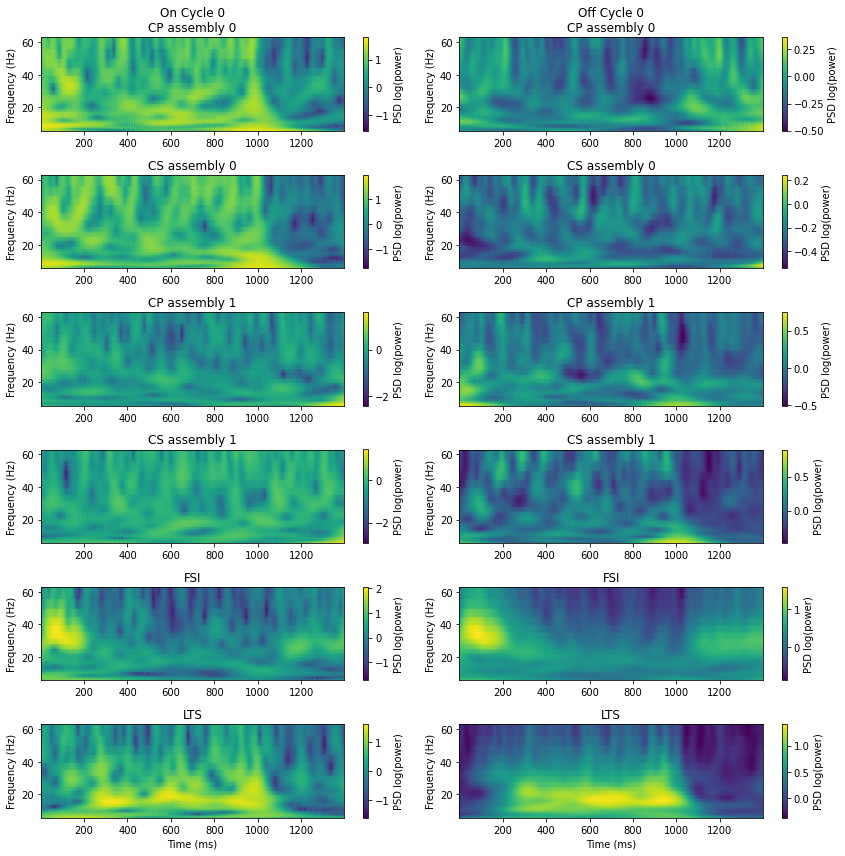

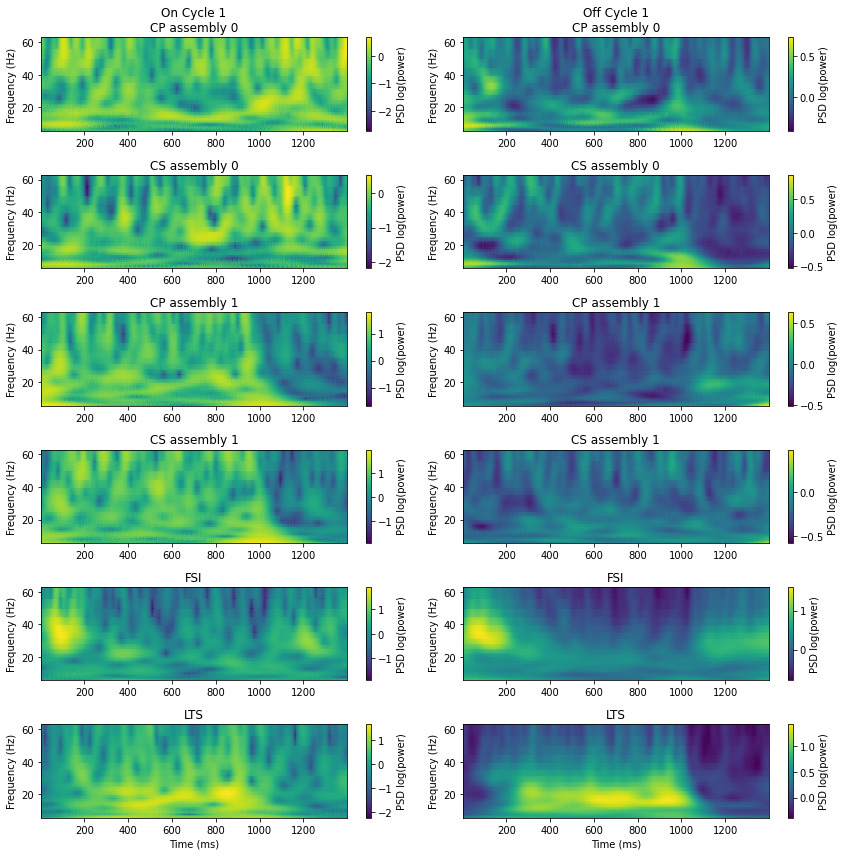

In [13]:
figsize = (6, 2)

def iterate_grp_psd(unique_cycle, onff, show_assy):
    for a in show_assy:
        for p in PN_pop_names:
            da = grp_psd_cyc_avg[onff].sel(unique_cycle=unique_cycle, assembly=a, population=p)
            yield da.mean_.to_dataset(name='PSD'), group_names[(a, p)]
    for p in ITN_pop_names:
        da = pop_psd_cyc_avg[onff].sel(unique_cycle=unique_cycle, population=p)
        yield da.mean_.to_dataset(name='PSD'), p

for i in show_unique_cyc:
    show_assy = cyc_to_assy[i] + ([-1] if rest_assy else [])
    n_rows = len(show_assy) * len(PN_pop_names) + len(ITN_pop_names)
    _, axs = plt.subplots(n_rows, show_off, squeeze=False,
                          figsize=(figsize[0] * show_off, figsize[1] * n_rows))
    for j in range(show_off):
        for k, (da, grp_name) in enumerate(iterate_grp_psd(i, j, show_assy)):
            ax = axs[k, j]
            _ = plot.plot_spectrogram(da, log_power=True, ax=ax)
            ax.set_title(('' if k else ('Off' if j else 'On') + f' Cycle {i:d}\n') + grp_name)
            ax.set_xlabel('')
        ax.set_xlabel('Time (ms)')
    plt.tight_layout()
plt.show()

### Population trajectory

In [14]:
marker_kwargs = dict(
    marker_times = np.array((t_cyc[0], 1000 * on_time, t_cyc[-1])),
    marker_names = ['stimulus on', 'stimulus off', 'cycle end'],
    marker_props = dict(
        marker = ['o', 'x', '^'],
        markeredgecolor = ['orange', 'darkred', 'g'],
        markeredgewidth = 1.5
    ),
    traj_props = dict(linewidth=1.5),
    diag_props = dict(linewidth=1.5),
    arrow_props = dict(linewidth=2),
    arrow_loc = [[0.47, 0.53], [0.24, 0.25]]
)

#### Trajectories among PN assemblies

On Cycle 0


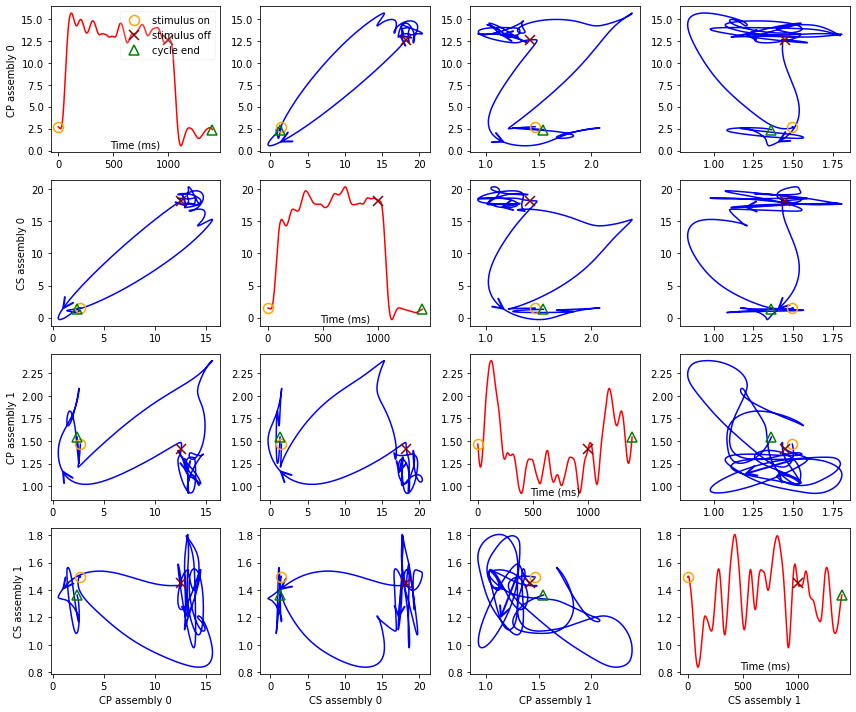

Off Cycle 0


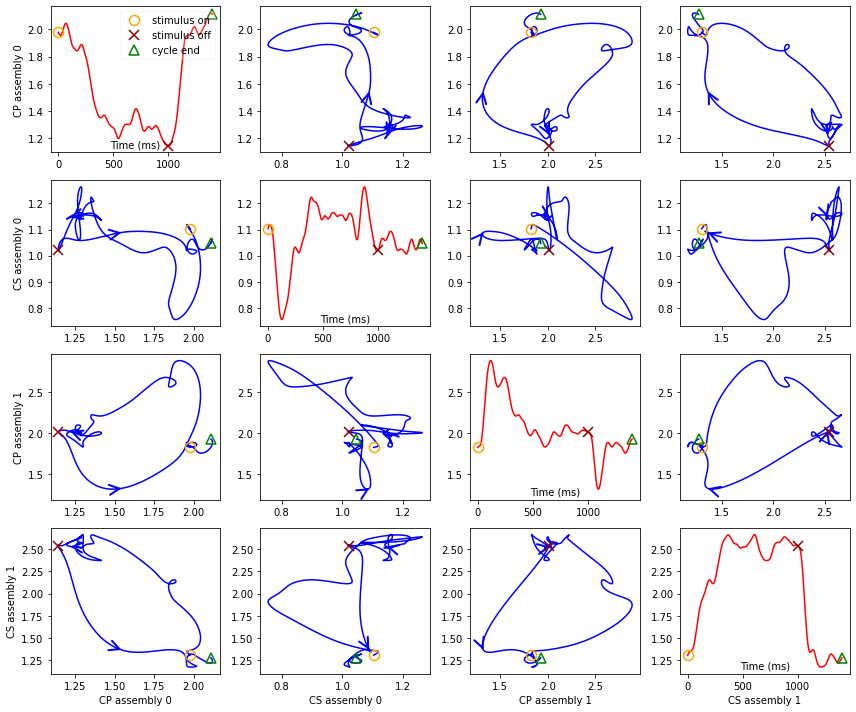

On Cycle 1


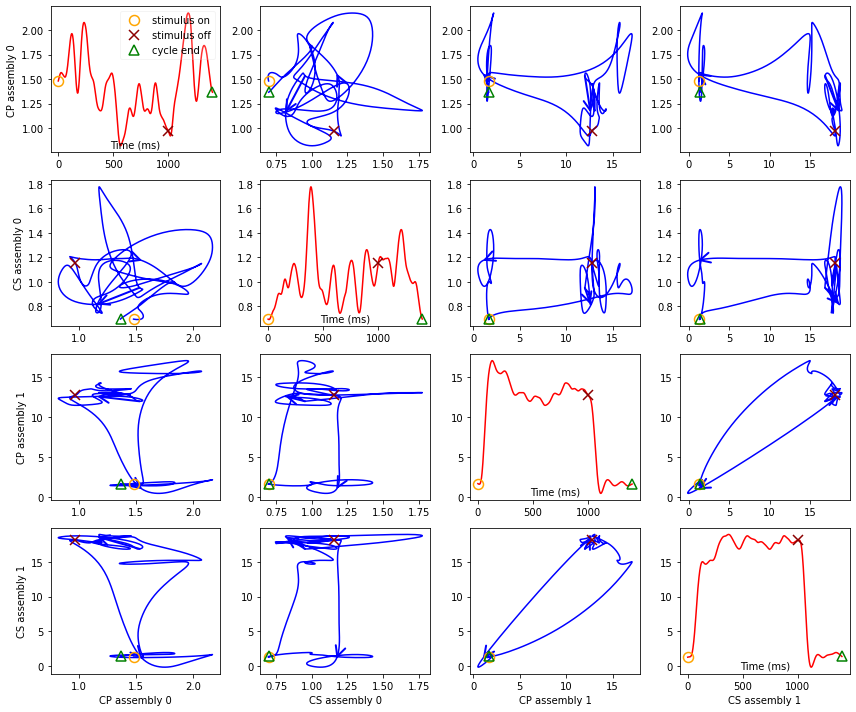

Off Cycle 1


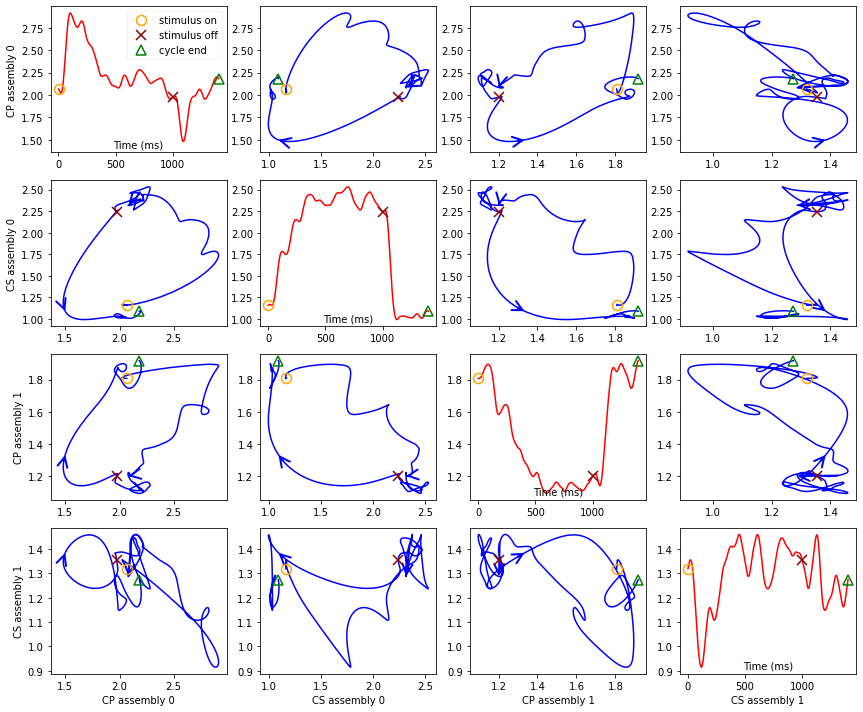

In [15]:
for i in show_unique_cyc:
    show_assy = cyc_to_assy[i] + ([-1] if rest_assy else [])
    for j in range(show_off):
        print(('Off' if j else 'On') + f' Cycle {i:d}')
        da = grp_rspk_cyc_avg[j].mean_.sel(unique_cycle=i).stack(group=('assembly', 'population'))
        rspk = {group_names[g]: da.sel(group=g) for g in group_names if g[0] in show_assy}
        axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs)
        plt.show()

#### Trajectories on PN assemblies and ITNs

On Cycle 0


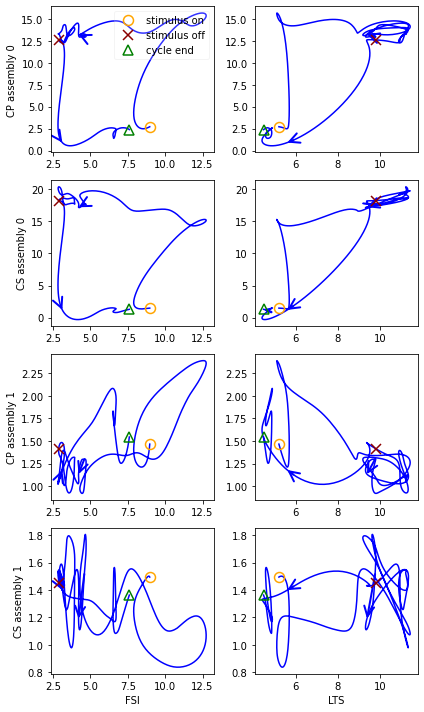

Off Cycle 0


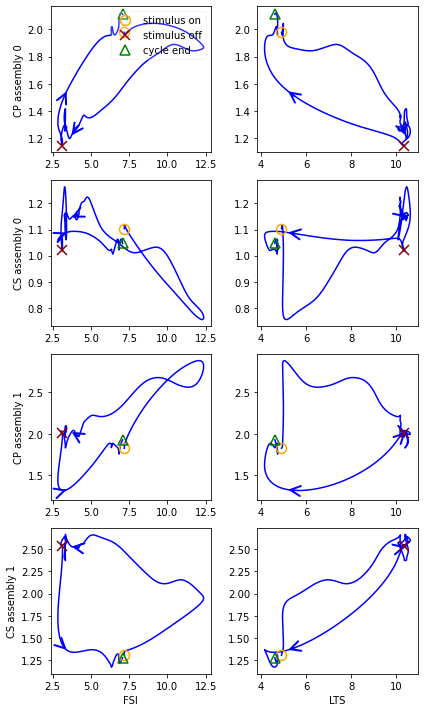

On Cycle 1


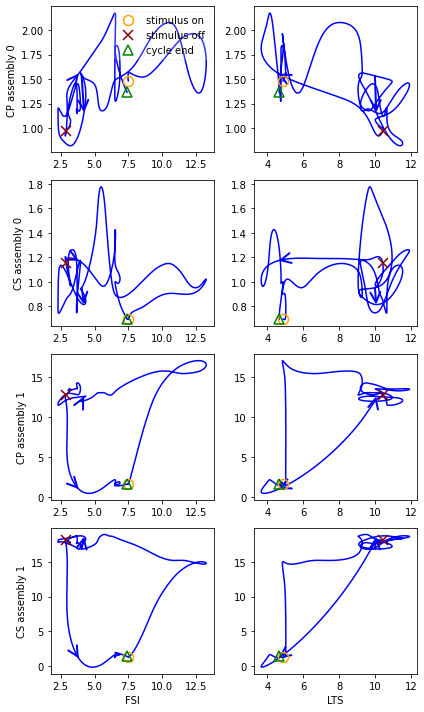

Off Cycle 1


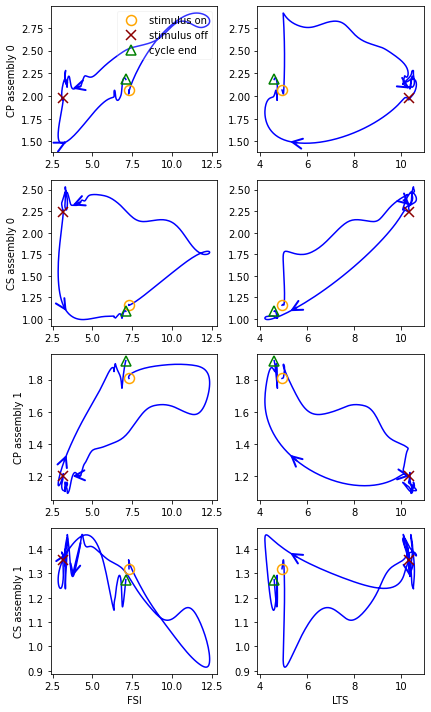

In [16]:
for i in show_unique_cyc:
    show_assy = cyc_to_assy[i] + ([-1] if rest_assy else [])
    for j in range(show_off):
        print(('Off' if j else 'On') + f' Cycle {i:d}')
        da = grp_rspk_cyc_avg[j].mean_.sel(unique_cycle=i).stack(group=('assembly', 'population'))
        rspk = {group_names[g]: da.sel(group=g) for g in group_names if g[0] in show_assy}
        ylabels = list(rspk)
        da = pop_rspk_cyc_avg[j].mean_.sel(unique_cycle=i)
        rspk.update({p: da.sel(population=p) for p in ITN_pop_names})
        axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs,
                                       xlabels=ITN_pop_names, ylabels=ylabels)
        plt.show()

In [17]:
PN_group_names = {a: 'PN ' + assy_names[a] for a in assy_ids}

grp_rspk_PN = process.combine_spike_rate(grp_rspk, dim='population')
_, _, PN_grp_rspk_cyc_avg = process.get_windowed_data(
    grp_rspk_PN.smoothed_spike_rate, windows, win_grp_idx)

On Cycle 0


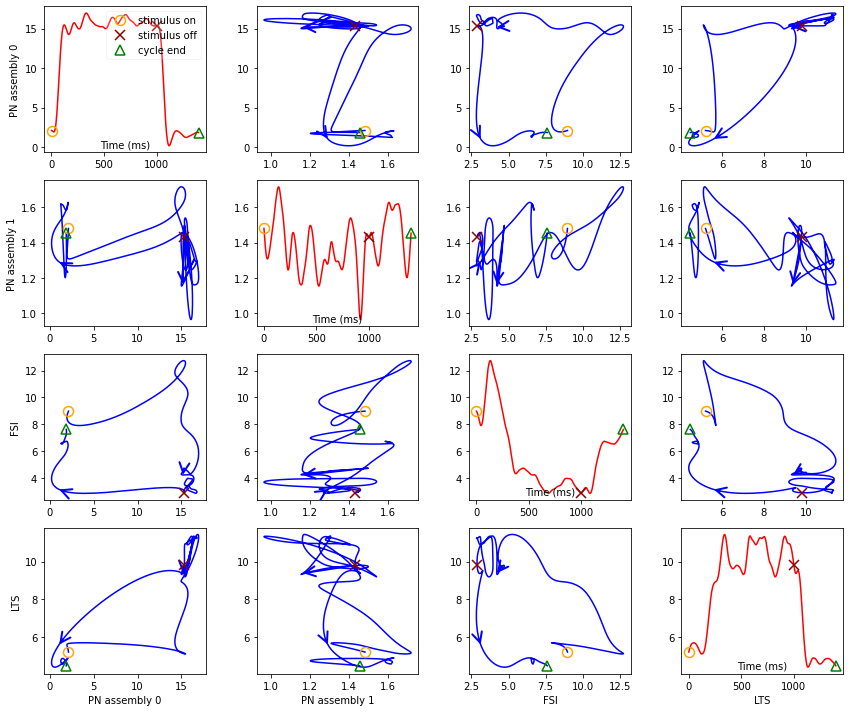

Off Cycle 0


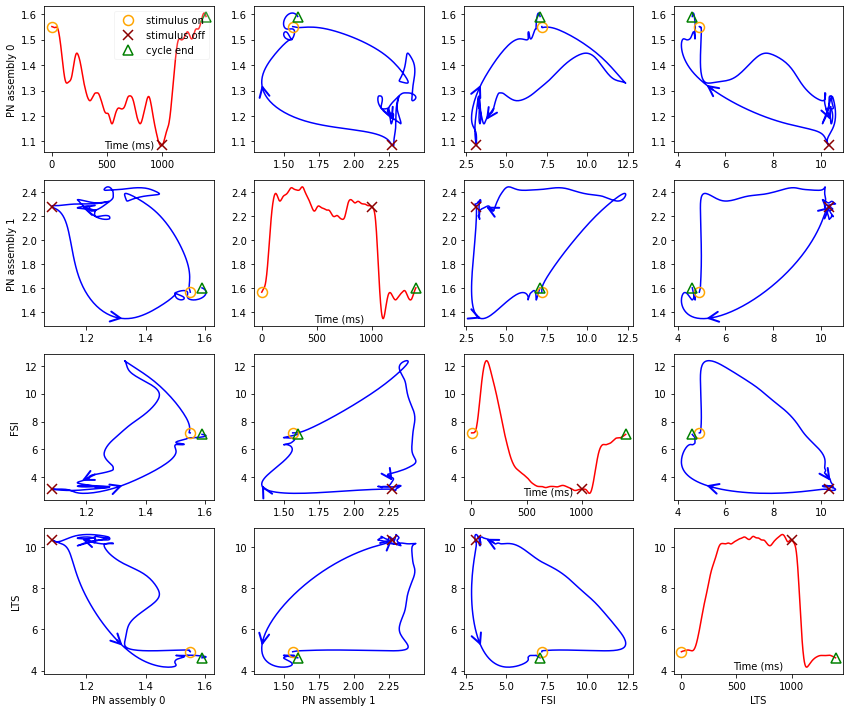

On Cycle 1


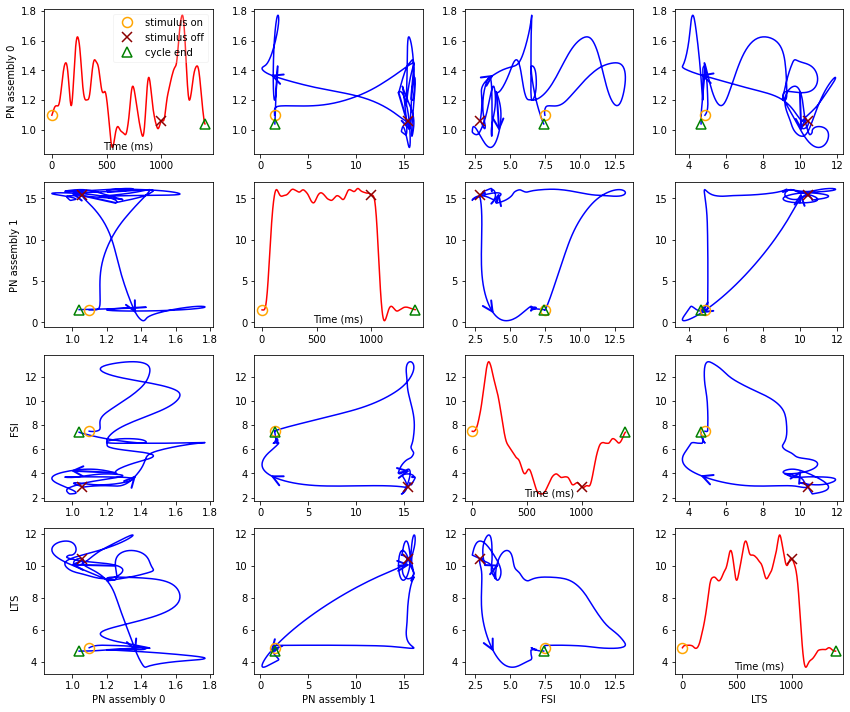

Off Cycle 1


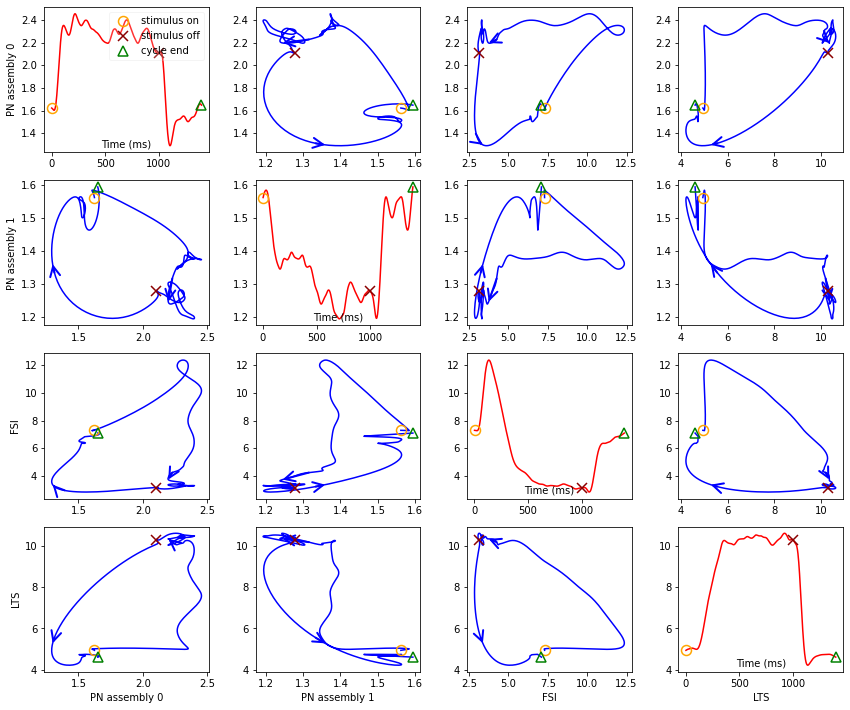

In [18]:
for i in show_unique_cyc:
    show_assy = cyc_to_assy[i] + ([-1] if rest_assy else [])
    for j in range(show_off):
        print(('Off' if j else 'On') + f' Cycle {i:d}')
        da = PN_grp_rspk_cyc_avg[j].mean_.sel(unique_cycle=i)
        rspk = {PN_group_names[a]: da.sel(assembly=a) for a in show_assy}
        da = pop_rspk_cyc_avg[j].mean_.sel(unique_cycle=i)
        rspk.update({p: da.sel(population=p) for p in ITN_pop_names})
        axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs)
        plt.show()

### Dispersion of population activities

In [19]:
filt_sigma = 50.0  # ms. Gaussian filer sigma. Affects PCA explained variance
fs = 100.
time = np.linspace(0., 1000. * t_stop, int(t_stop * fs), endpoint=False)

# Unit firing rates
PN_node_ids = np.concatenate([pop_ids[p] for p in PN_pop_names])
unit_rspk = process.unit_spike_rate_to_xarray(spikes_df, time, PN_node_ids,
    frequeny=True, filt_sigma=filt_sigma)
inactive_units = ~np.any(unit_rspk, axis=1)
# unit_rspk -= unit_rspk.mean(axis=1, keepdims=True)  # centered data

# Population direction vectors of assemblies
n_assy = len(assy_ids)
PN_idx = pd.Series(range(len(PN_node_ids)), index=PN_node_ids)
pop_pcs = np.zeros((n_assy, PN_idx.size))
for i, ids in enumerate(assy_ids.values()):
    pop_pcs[i, PN_idx[ids]] = 1
pop_pcs[:, inactive_units] = 0  # remove inactivate units

Alignment (cosine similarity) between PCs and population directions of assemblies


,assembly 0,assembly 1,assembly 2,assembly 3,assembly 4,assembly 5,assembly 6,assembly 7,assembly 8,assembly 9,...,assembly 13,assembly 14,assembly 15,assembly 16,assembly 17,assembly 18,assembly 19,max,max_assembly,total projection
PCs,,,,,,,,,,,,,,,,,,,,,
0,0.169,0.100,0.571,0.041,0.012,0.435,0.067,0.110,0.344,0.263,...,0.002,0.009,0.010,0.015,0.005,0.001,0.008,0.571,assembly 2,0.872
1,0.166,0.043,0.309,0.011,0.098,0.287,0.031,0.193,0.679,0.218,...,0.015,0.001,0.003,0.001,0.002,0.007,0.000,0.679,assembly 8,0.874
2,0.773,0.134,0.217,0.077,0.018,0.181,0.050,0.019,0.154,0.181,...,0.009,0.000,0.010,0.001,0.007,0.004,0.008,0.773,assembly 0,0.873
3,0.107,0.061,0.363,0.200,0.001,0.331,0.036,0.131,0.244,0.623,...,0.000,0.006,0.003,0.007,0.001,0.003,0.005,0.623,assembly 9,0.874
4,0.074,0.541,0.164,0.033,0.155,0.445,0.197,0.237,0.171,0.300,...,0.008,0.009,0.004,0.001,0.013,0.004,0.001,0.541,assembly 1,0.873
5,0.058,0.314,0.213,0.331,0.007,0.026,0.019,0.682,0.064,0.176,...,0.013,0.006,0.007,0.002,0.017,0.012,0.002,0.682,assembly 7,0.871
6,0.135,0.421,0.128,0.432,0.548,0.223,0.062,0.020,0.007,0.116,...,0.001,0.000,0.001,0.008,0.008,0.004,0.005,0.548,assembly 4,0.875
7,0.002,0.053,0.049,0.568,0.574,0.149,0.031,0.286,0.043,0.024,...,0.007,0.011,0.013,0.007,0.010,0.009,0.009,0.574,assembly 4,0.875
8,0.058,0.278,0.092,0.050,0.135,0.018,0.790,0.133,0.004,0.114,...,0.004,0.017,0.004,0.011,0.010,0.002,0.004,0.790,assembly 6,0.875


Leading components explained variance: 3.2%, 3.2%, 3.2%, 3.1%, 3.1%, 3.0%, 3.0%, 3.0%, 2.9%, 2.3%, 1.8%, 1.8%, 1.7%, 1.7%, 1.7%, 1.6%, 1.6%, 1.6%, 1.5%, 1.0%, 0.4%


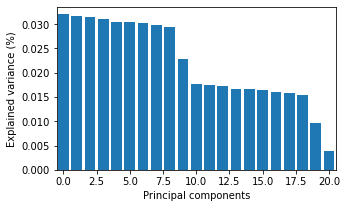

In [20]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

n_components = max(n_assy + 1, 5)
pca = PCA(n_components=n_components)
pca.fit(unit_rspk.T)

# Cosine similarity between PCs and direction vectors of assemblies
cosvec_mat = np.abs(cosine_similarity(pca.components_, pop_pcs))
cosvec = pd.DataFrame(cosvec_mat, columns=assy_names.values(),
                      index=pd.Index(range(pca.components_.shape[0]), name='PCs'))
cosvec['max'] = cosvec.max(axis=1)
cosvec['max_assembly'] = [cosvec.columns[i] for i in np.argmax(cosvec.values, axis=1)]
cosvec['total projection'] = np.sum(cosvec_mat ** 2, axis=1) ** 0.5
print("Alignment (cosine similarity) between PCs and population directions of assemblies")
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(cosvec)

# Explained variance
explained_var = pca.explained_variance_ratio_[:n_assy + 1]
print("Leading components explained variance:",
      ', '.join('%.1f%%' % x for x in 100. * explained_var))

plt.figure(figsize=(5, 3))
plt.bar(np.arange(n_components), pca.explained_variance_ratio_)
plt.xlim(-0.5, n_components - 0.5)
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')
plt.show()